# Feature Engineering

This notebook will cover some unsupervised machine learning techniques to classify features in a data set. The first application we will consider is k-means clustering. Below we will first discover how to identify which features give us useful information.

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import mutual_info_regression

plt.style.use("seaborn-whitegrid")

## Load data

In [25]:
# Load data
df = pd.read_csv("Automobile_data.csv")
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [26]:
# Choose parameter to be fitted
y_label = 'horsepower'

In [27]:
X = df.copy()
y = X.pop(y_label)

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
#     if X[colname].dtype == int:
#         i_int = np.where(X[colname] == '?')[0]
#         X[colname].iloc[i_int] = np.nan
#         i_int = np.where(X[colname] != '?')[0]
#         X[colname].iloc[i_int] = pd.to_numeric(X[colname].iloc[i_int])

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int
# discrete_features

## Mutual Information

In [28]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

i_int = np.where(y != '?')[0]
mi_scores = make_mi_scores(X.iloc[i_int, :].fillna(0), y[i_int].fillna(0), discrete_features)
mi_scores[::3]  # show a few features with their MI scores

engine-size          1.687178
city-mpg             1.395108
wheel-base           1.311576
peak-rpm             1.148142
price                0.821233
normalized-losses    0.573014
num-of-cylinders     0.375758
aspiration           0.172395
engine-location      0.004571
Name: MI Scores, dtype: float64

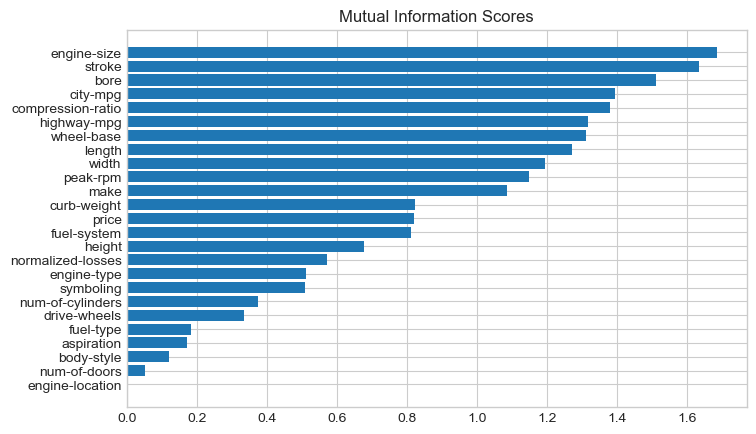

In [29]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [19]:
df.loc[:, 'drive-wheels'].unique()

array(['rwd', 'fwd', '4wd'], dtype=object)

In [ ]:
colnames = ['curbweight',
            'horsepower',
            'engine-size',
            'highway-mpg',
            'city-mpg',
            'stroke',
            '',
            '',
            '',
            '',
            '']

## Plotting

In [30]:
def clean_frame(df, colnames=None):
    df_final = df.copy()
    if colnames == None:
        colnames = df_final.columns
    for column in colnames:
        if df[column].dtype == 'object':
            pass
        i_int = np.where(df[column] != '?')[0]
        df_final.loc[i_int, column] = pd.to_numeric(df.loc[i_int, column])
        
def sns_relplot(df, x, y, hue=None, **kwargs):
    i_int = np.where((df[x] != '?') & (df[y] != '?'))[0]
    df_final = df.iloc[i_int].copy()
    df_final.loc[:, x] = pd.to_numeric(df.loc[i_int, x])
    df_final.loc[:, y] = pd.to_numeric(df.loc[i_int, y])
    sns.relplot(x=x, y=y, hue=hue, data=df_final, **kwargs)
        
def sns_lmplot(df, x, y, hue=None, **kwargs):
    i_int = np.where((df[x] != '?') & (df[y] != '?'))[0]
    df_final = df.iloc[i_int].copy()
    df_final.loc[:, x] = pd.to_numeric(df.loc[i_int, x])
    df_final.loc[:, y] = pd.to_numeric(df.loc[i_int, y])
    sns.lmplot(x=x, y=y, hue=hue, data=df_final, **kwargs)

Use `relplot` to show a scatter plot of the data. The `hue` kwarg can be set to display categorical data

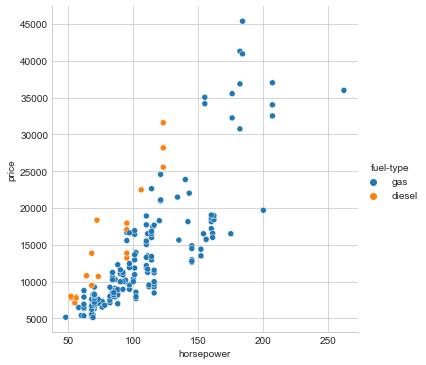

In [40]:
sns.relplot(data=df, x="horsepower", y="price", hue="fuel-type");

Use `lmplot` to also show the linear fits to the data. Note that this requires $x, y$ to both be *int* or *float* type data (continuous rather than categorical).

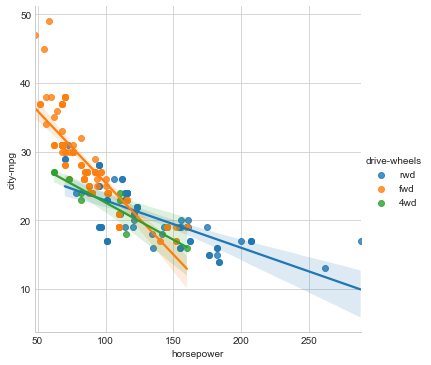

In [43]:
sns.lmplot(data=df, x="horsepower", y="city-mpg", hue="drive-wheels");

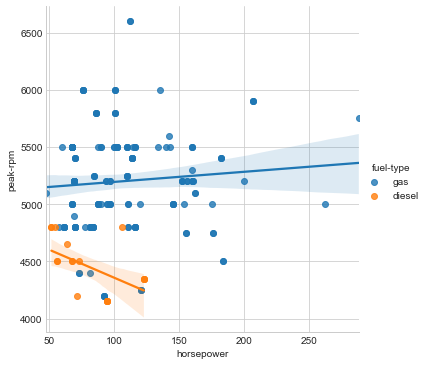

In [51]:
sns.lmplot(data=df, x="horsepower", y="peak-rpm", hue="fuel-type");

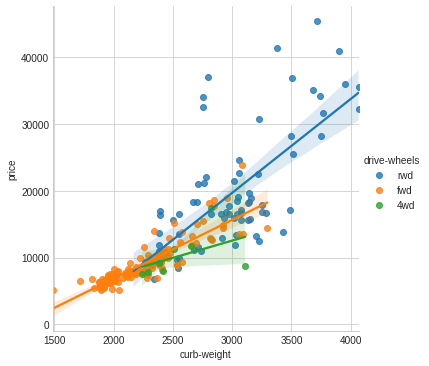

In [40]:
sns.lmplot(data=df, x="curb-weight", y="price", hue="drive-wheels");

use the `kdeplot` method to plot contours of the data

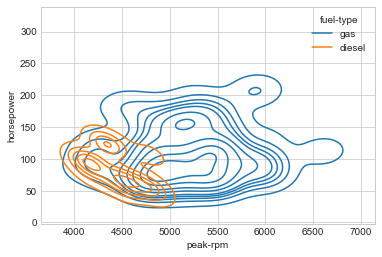

In [53]:
sns.kdeplot(data=df, x='peak-rpm', y='horsepower', hue='fuel-type');

## $k$-means clustering

Finally we arrive at using k-means clustering to identify individual groups in the data.The k value (number of clusters) is given as an argument when using this method. Note that the features used in the clustering algorithm must be of type *int* or *float*.

In [5]:
from sklearn.cluster import KMeans

In [12]:
df_final = df.copy()

for colname in df_final.select_dtypes("object"):
    df_final[colname], _ = df_final[colname].factorize()

k_means = KMeans(n_clusters=3)
df_final['Cluster'] = k_means.fit_predict(df_final.loc[:, ['price', 'curb-weight', 'horsepower']].fillna(0))
df_final

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,Cluster
0,3,NaN,0,0,0,0,0,0,0,88.6,...,0,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0,2
1,3,NaN,0,0,0,0,0,0,0,88.6,...,0,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0,2
2,1,NaN,0,0,0,0,1,0,0,94.5,...,0,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0,2
3,2,164.0,1,0,0,1,2,1,0,99.8,...,0,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0,2
4,2,164.0,1,0,0,1,2,2,0,99.4,...,0,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.0,21,0,0,1,2,0,0,109.1,...,0,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0,2
201,-1,95.0,21,0,1,1,2,0,0,109.1,...,0,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0,2
202,-1,95.0,21,0,0,1,2,0,0,109.1,...,0,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0,2
203,-1,95.0,21,1,1,1,2,0,0,109.1,...,6,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0,2


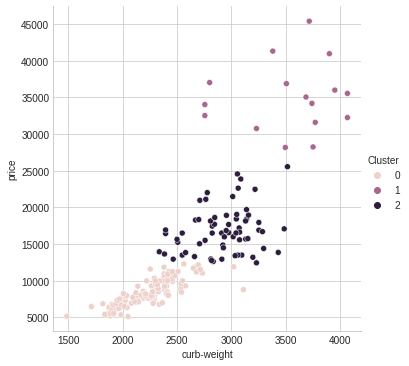

In [13]:
sns.relplot(data=df_final, x="curb-weight", y="price", hue="Cluster");

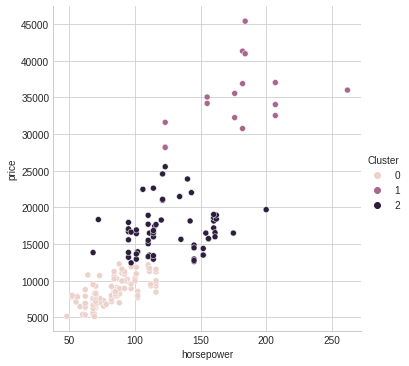

In [14]:
sns.relplot(data=df_final, x="horsepower", y="price", hue="Cluster");

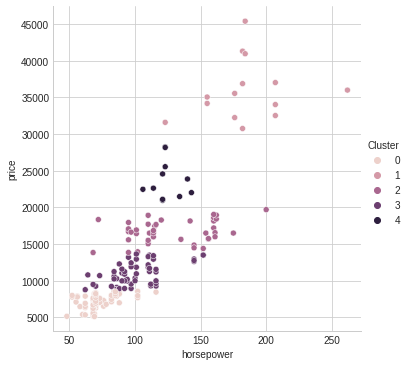

In [53]:
sns.relplot(data=df_final, x="horsepower", y="price", hue="Cluster");

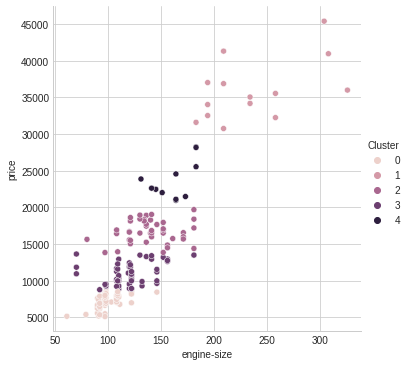

In [56]:
sns.relplot(data=df_final, x="engine-size", y="price", hue="Cluster");